Train Accuracy: 10.56%
Number of Epoch = 1 - Average Cross Entropy:= 0.17834018841911764
Train Accuracy: 11.01%
Number of Epoch = 2 - Average Cross Entropy:= 0.1773899165134804
Train Accuracy: 11.44%
Number of Epoch = 3 - Average Cross Entropy:= 0.176533509497549
Train Accuracy: 11.84%
Number of Epoch = 4 - Average Cross Entropy:= 0.17576321231617648
Train Accuracy: 12.14%
Number of Epoch = 5 - Average Cross Entropy:= 0.1751768727022059
Train Accuracy: 12.36%
Number of Epoch = 6 - Average Cross Entropy:= 0.1746957529105392
Train Accuracy: 12.65%
Number of Epoch = 7 - Average Cross Entropy:= 0.17410278799019607
Train Accuracy: 12.85%
Number of Epoch = 8 - Average Cross Entropy:= 0.17374381510416667
Train Accuracy: 12.99%
Number of Epoch = 9 - Average Cross Entropy:= 0.17346557138480392
Train Accuracy: 13.19%
Number of Epoch = 10 - Average Cross Entropy:= 0.17306868489583332
Train Accuracy: 13.36%
Number of Epoch = 11 - Average Cross Entropy:= 0.17273646216299018
Train Accuracy: 13.57%
N

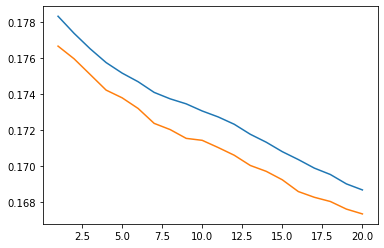

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import tensorflow as tf

a=1
np.random.seed(a*9755)
tf.random.set_seed(a*9755)

(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

X_val = X_train[int(0.85*X_train.shape[0]):int(X_train.shape[0])]
y_val = y_train[int(0.85*y_train.shape[0]):int(y_train.shape[0])]


X_train = X_train[0:int(0.85*X_train.shape[0])]
y_train = y_train[0:int(0.85*y_train.shape[0])]


X_train=X_train.reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
X_train=tf.cast(X_train,dtype=tf.float32)
X_train=X_train/255.0

X_val=X_val.reshape(X_val.shape[0],X_val.shape[1]*X_val.shape[2])
X_val=tf.cast(X_val,dtype=tf.float32)
X_val=X_val/255.0

size_input = X_train.shape[1]
size_input_layer = 64
size_first_hidden = 32
size_second_hidden = 16
size_output = 10 #The digits go from 0 to 9 so in total we should have 10 classes
y_train=tf.keras.utils.to_categorical(y_train,size_output)
y_val=tf.keras.utils.to_categorical(y_val,size_output)

# Define class to build mlp model
class MLP(object):
  def __init__(self, size_input,size_input_layer, size_first_hidden, size_second_hidden, size_output, device):
    """
    size_input: int, size of input layer
    size_hidden: int, size of hidden layer
    size_output: int, size of output layer
    device: str or None, either 'cpu' or 'gpu' or None. If None, the device to be used will be decided automatically during Eager Execution
    """
    self.size_input, self.size_input_layer, self.size_first_hidden, self.size_second_hidden, self.size_output, self.device =\
    size_input, size_input_layer, size_first_hidden, size_second_hidden, size_output, device
    
    # Initialize weights for input
    self.W1 = tf.Variable(tf.random.normal([self.size_input, self.size_input_layer]))
    # Initialize biases for input layer
    self.b1 = tf.Variable(tf.random.normal([1, self.size_input_layer]))
     # Initialize weights between input layer and first hidden layer
    self.W2 = tf.Variable(tf.random.normal([self.size_input_layer, self.size_first_hidden]))
    # Initialize biases for first hidden layer
    self.b2 = tf.Variable(tf.random.normal([1, self.size_first_hidden]))
     # Initialize weights between first hidden layer and second hidden layer
    self.W3 = tf.Variable(tf.random.normal([self.size_first_hidden, self.size_second_hidden]))
    # Initialize biases for second hidden layer
    self.b3 = tf.Variable(tf.random.normal([1, self.size_second_hidden]))
    # Initialize weights between second hidden layer and output layer
    self.W4 = tf.Variable(tf.random.normal([self.size_second_hidden, self.size_output]))
    # Initialize biases for output layer
    self.b4 = tf.Variable(tf.random.normal([1, self.size_output]))
    
    # Define variables to be updated during backpropagation
    self.variables = [self.W1, self.W2, self.W3, self.W4, self.b1, self.b2, self.b3, self.b4]
    
  def forward(self, X):
    """
    forward pass
    X: Tensor, inputs
    """
    if self.device is not None:
      with tf.device('gpu:0' if self.device=='gpu' else 'cpu'):
        self.y = self.compute_output(X)
    else:
      self.y = self.compute_output(X)
      
    return self.y
  
  def loss(self, y_pred, y_true):
    '''
    y_pred - Tensor of shape (batch_size, size_output)
    y_true - Tensor of shape (batch_size, size_output)
    '''
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)
    return tf.losses.mean_squared_error(y_true_tf, y_pred_tf)
  
  def backward(self, X_train, y_train):
    """
    backward pass
    """
    optimizer = tf.keras.optimizers.SGD(learning_rate=1e-4)
    with tf.GradientTape() as tape:
      predicted = self.forward(X_train)
      current_loss = self.loss(predicted, y_train)
    grads = tape.gradient(current_loss, self.variables)
    optimizer.apply_gradients(zip(grads, self.variables))
        
        
  def compute_output(self, X):
    """
    Custom method to obtain output tensor during forward pass
    """
    # Cast X to float32
    X_tf = tf.cast(X, dtype=tf.float32)
    #Remember to normalize your dataset before moving forward
    #Compute values in input layer
    what = tf.matmul(X_tf, self.W1) + self.b1
    hhat = tf.nn.relu(what)    
    # Compute values in first hidden layer
    what = tf.matmul(hhat, self.W2) + self.b2
    hhat = tf.nn.relu(what)
    # Compute values in second hidden layer
    what = tf.matmul(hhat, self.W3) + self.b3
    hhat = tf.nn.relu(what)
    # Compute output
    output = tf.matmul(hhat, self.W4) + self.b4
    return tf.nn.softmax(output)

  def compute_correct_preds(self, y_pred, y_true):
    y_true_tf = tf.cast(tf.reshape(y_true, (-1, self.size_output)), dtype=tf.float32)
    y_pred_tf = tf.cast(y_pred, dtype=tf.float32)

    correct = tf.Variable(0, dtype=tf.float32)
    for i in range(y_pred_tf.shape[0]):
      if tf.argmax(y_pred_tf[i]) == tf.argmax(y_true_tf[i]):
        correct = correct + 1.0
    return correct   


# Set number of epochs
NUM_EPOCHS = 20

# Initialize model using CPU
mlp_on_cpu = MLP(size_input, size_input_layer, size_first_hidden, size_second_hidden, size_output, device='none')

time_start = time.time()
valo_loss = 100.0
val_loss  = tf.Variable(tf.zeros([1, NUM_EPOCHS]),dtype=tf.float32)
train_loss = tf.Variable(tf.zeros([1, NUM_EPOCHS]),dtype=tf.float32)
for epoch in range(NUM_EPOCHS):
  loss_total = tf.zeros([1,1], dtype=tf.float32)
  lt = 0
  train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(25, seed=epoch*a*(9755)).batch(20)
  correct_preds = tf.Variable(0, dtype=tf.float32)
  for inputs, outputs in train_ds:
    preds = mlp_on_cpu.forward(inputs)
    loss_total = loss_total + mlp_on_cpu.loss(preds, outputs)
    lt = lt + mlp_on_cpu.loss(preds, outputs)
    mlp_on_cpu.backward(inputs, outputs)
    correct_preds = correct_preds + mlp_on_cpu.compute_correct_preds(preds, outputs)

  train_loss[0,epoch].assign(np.sum(loss_total) / X_train.shape[0])
  print('Train Accuracy: {:.2f}%'.format((correct_preds/X_train.shape[0])*100.0))
  print('Number of Epoch = {} - Average Cross Entropy:= {}'.format(epoch + 1, np.sum(loss_total) / X_train.shape[0]))

  val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(4)
  valn_loss = tf.Variable(0, dtype=tf.float32)

  for inputs, outputs in val_ds:
    preds = mlp_on_cpu.forward(inputs)
    valn_loss = valn_loss + mlp_on_cpu.loss(preds, outputs)
  val_loss[0,epoch].assign(np.sum(valn_loss) / X_val.shape[0])
  if val_loss[0,epoch] > valo_loss:
    break
  else:
    valo_loss = val_loss[0,epoch]
    W1 = mlp_on_cpu.variables[0]
    W2 = mlp_on_cpu.variables[1]
    W3 = mlp_on_cpu.variables[2]
    W4 = mlp_on_cpu.variables[3]
    b1 = mlp_on_cpu.variables[4]
    b2 = mlp_on_cpu.variables[5]
    b3 = mlp_on_cpu.variables[6]
    b4 = mlp_on_cpu.variables[7]


time_taken = time.time() - time_start
print('\nTotal time taken (in seconds): {:.2f}'.format(time_taken))
#For per epoch_time = Total_Time / Number_of_epochs

train_loss = train_loss[train_loss>0.0]
val_loss = val_loss[val_loss>0.0]
e = e = tf.range(1, epoch+2, 1)
plt.plot(e.numpy(),train_loss.numpy(),e.numpy(),val_loss.numpy())

mlp_on_cpu.variables[0].assign(W1)
mlp_on_cpu.variables[1].assign(W2)
mlp_on_cpu.variables[2].assign(W3)
mlp_on_cpu.variables[3].assign(W4)
mlp_on_cpu.variables[4].assign(b1)
mlp_on_cpu.variables[5].assign(b2)
mlp_on_cpu.variables[6].assign(b3)
mlp_on_cpu.variables[7].assign(b4)

X_test=X_test.reshape(X_test.shape[0],X_test.shape[1]*X_test.shape[2])
X_test=tf.cast(X_test,dtype=tf.float32)
X_test=X_test/255.0

y_test=tf.keras.utils.to_categorical(y_test,size_output)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(4)

test_loss_total = tf.Variable(0, dtype=tf.float32)
correct_preds = tf.Variable(0, dtype=tf.float32)
for inputs, outputs in test_ds:
  preds = mlp_on_cpu.forward(inputs)
  test_loss_total = test_loss_total + mlp_on_cpu.loss(preds, outputs)
  correct_preds = correct_preds + mlp_on_cpu.compute_correct_preds(preds, outputs)
print('Test Accuracy: {:.2f}%'.format((correct_preds/X_test.shape[0])*100.0))
print('Test MSE: {:.4f}'.format(np.sum(test_loss_total.numpy()) / X_test.shape[0]))